In [1]:
import math
import os
import torch
import time
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import rmse
from darts.metrics import smape
from darts.metrics import mae
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import StochasticWeightAveraging
from darts.metrics import rmse, smape

In [2]:
CSV = "2107_inv1_env_irradiance_interp.csv"

# Load & prepare
df = pd.read_csv(CSV)
df['measured_on'] = pd.to_datetime(df['measured_on'], errors='coerce')
df = df.dropna(subset=['measured_on']).sort_values('measured_on').reset_index(drop=True)

has_ac  = 'inv1_ac_power' in df.columns
has_irr = 'poa_irradiance_o_149574' in df.columns
has_amb = 'ambient_temperature_o_149575' in df.columns

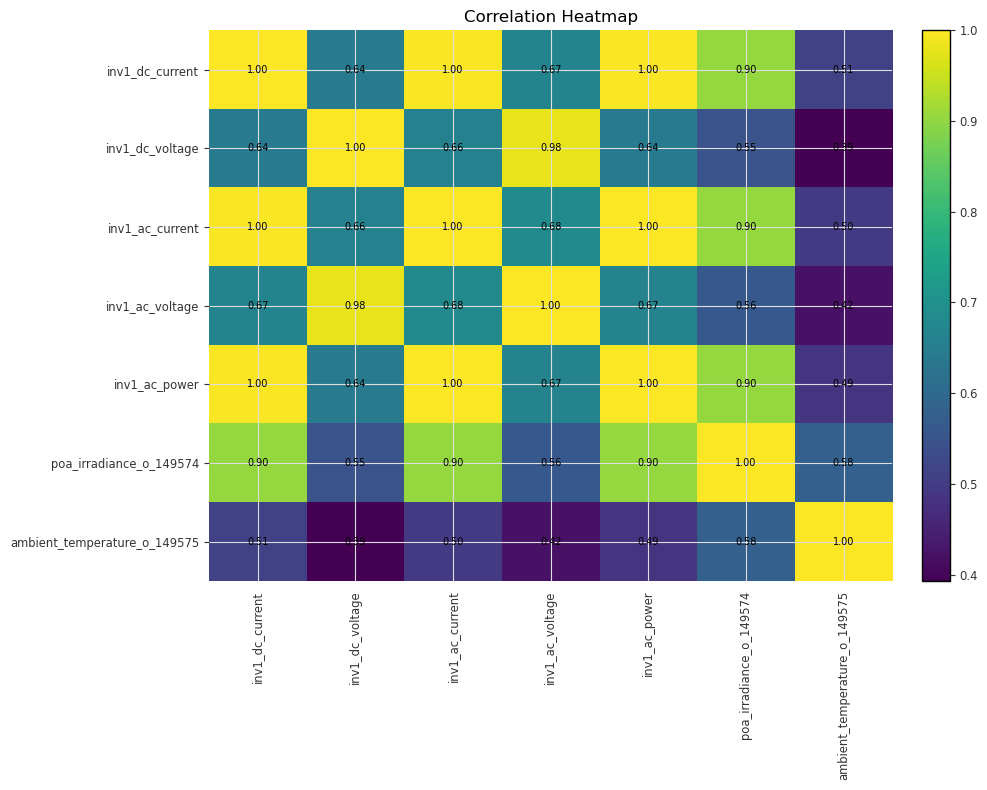

In [3]:
# Correlation heatmap
num_cols = df.select_dtypes(include=np.number).columns.tolist()
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    plt.figure(figsize=(10, 8))
    im = plt.imshow(corr, aspect='auto')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title('Correlation Heatmap')
    for i in range(len(num_cols)):
        for j in range(len(num_cols)):
            plt.text(j, i, f"{corr.values[i,j]:.2f}", ha='center', va='center', fontsize=7)
    plt.tight_layout(); plt.show()

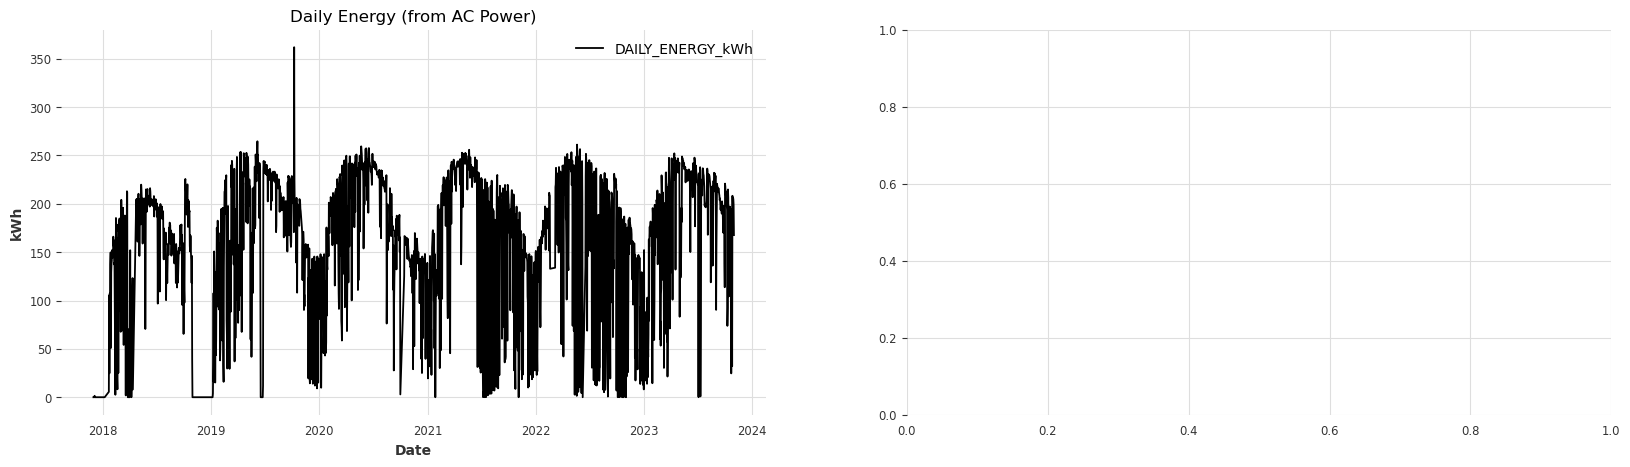

In [4]:
# Daily energy (AC power only) & AC power by time-of-day 
def daily_energy_kwh(ts_time, ts_power_kw):
    s = pd.DataFrame({'ts': ts_time, 'p_kw': ts_power_kw}).dropna().sort_values('ts')
    dt_h = s['ts'].diff().dt.total_seconds().div(3600.0); dt_h.iloc[0] = 0.0
    return (s['p_kw'] * dt_h).sum()

if has_ac:
    # Group by calendar date from measured_on, compute energy
    daily_e = (
        df.groupby(df['measured_on'].dt.date)
          .apply(lambda g: daily_energy_kwh(g['measured_on'], g['inv1_ac_power']))
          .rename('DAILY_ENERGY_kWh')
          .reset_index()                      # <— gives a column with the date
    )
    daily_e.columns = ['DATE', 'DAILY_ENERGY_kWh']  # <— name it explicitly

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,5), dpi=100)

    # Plot daily energy
    daily_e.plot(x='DATE', y='DAILY_ENERGY_kWh', ax=ax1)
    ax1.set_title('Daily Energy (from AC Power)')
    ax1.set_xlabel('Date'); ax1.set_ylabel('kWh')


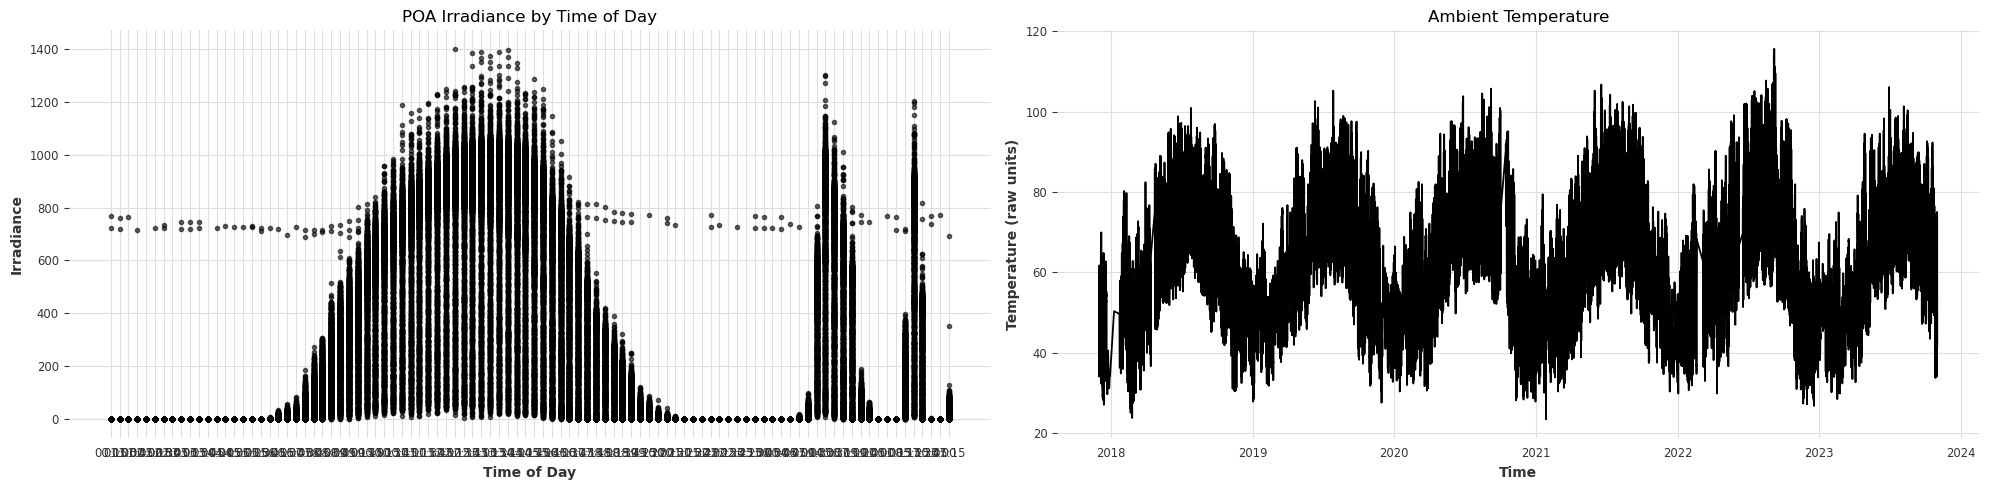

In [5]:
# Irradiance vs time-of-day & Ambient temperature over time
if has_irr or has_amb:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,5), dpi=100)

    if has_irr:
        tod = df['measured_on'].dt.strftime('%H:%M')
        ax1.plot(tod, df['poa_irradiance_o_149574'], '.', alpha=0.6)
        ax1.set_title('POA Irradiance by Time of Day'); ax1.set_xlabel('Time of Day'); ax1.set_ylabel('Irradiance')
    else:
        ax1.axis('off'); ax1.set_title('POA Irradiance not in file')

    if has_amb:
        ax2.plot(df['measured_on'], df['ambient_temperature_o_149575'])
        ax2.set_title('Ambient Temperature'); ax2.set_xlabel('Time'); ax2.set_ylabel('Temperature (raw units)')
    else:
        ax2.axis('off'); ax2.set_title('Ambient Temperature not in file')

    plt.tight_layout(); plt.show()

Ambient temperature describe:
 count    175566.00000
mean         63.20852
std          15.71103
min          23.40000
25%          51.10000
50%          62.00000
75%          74.60000
max         115.60000


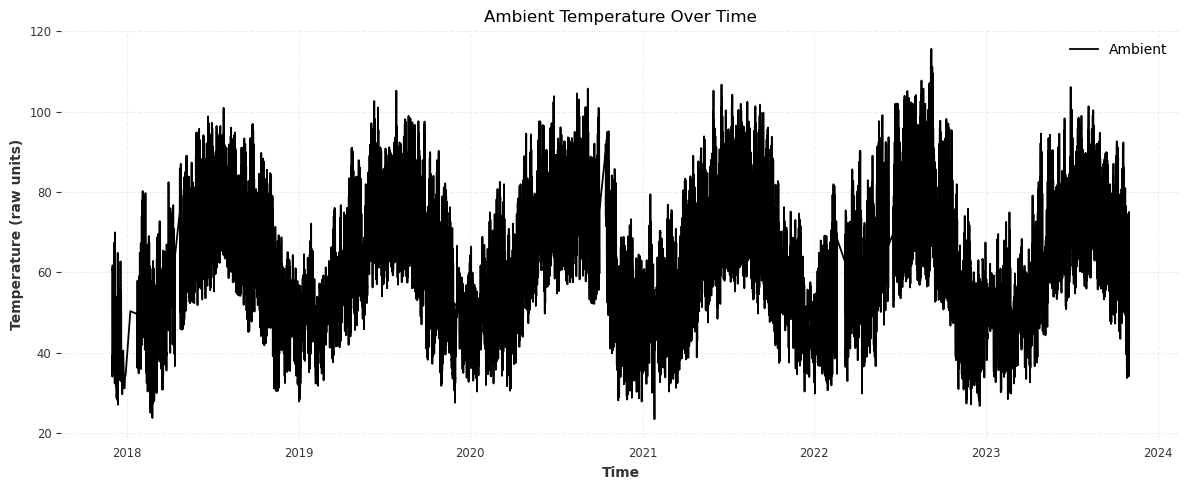

In [6]:
# Ambient describe & line plot
if has_amb:
    print("Ambient temperature describe:\n", df['ambient_temperature_o_149575'].describe().to_string())
    plt.figure(figsize=(12,5))
    plt.plot(df['measured_on'], df['ambient_temperature_o_149575'], label='Ambient')
    plt.title('Ambient Temperature Over Time'); plt.xlabel('Time'); plt.ylabel('Temperature (raw units)')
    plt.grid(True, linestyle='--', alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()

In [7]:
# Fault flag: irradiance == 0 & AC power > 0 
import numpy as np
import pandas as pd
from IPython.display import display

if has_ac and has_irr:
    IRR_COL, AC_COL = 'poa_irradiance_o_149574', 'inv1_ac_power'
    IRR_EPS = 0.0  # exact zero per your rule

    mask = (df[IRR_COL].fillna(0) <= IRR_EPS) & (df[AC_COL].fillna(0) > 0)
    faults = (
        df.loc[mask, ['measured_on', IRR_COL, AC_COL]]
          .sort_values('measured_on')
          .reset_index(drop=True)
    )

    # 1) Total count
    total = len(faults)
    print(f"Fault rows (irr==0 & AC>0): {total} / {len(df)} ({100*total/max(len(df),1):.4f}%)")

    # 2) Show ALL fault timestamps + values (safe here since it's small)
    #    If this is too long in your notebook, change to .head(50)
    print("\nAll fault rows (timestamp, irradiance, AC power):")
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
        display(faults)

    # 3) Quick text summaries
    by_date = faults.groupby(faults['measured_on'].dt.date).size().rename("count").sort_values(ascending=False)
    by_tod  = faults['measured_on'].dt.strftime('%H:%M').value_counts().sort_index()

    print("\nFault counts by DATE (descending):")
    with pd.option_context('display.max_rows', None):
        display(by_date)

    print("\nFault counts by TIME-OF-DAY (HH:MM):")
    with pd.option_context('display.max_rows', None):
        display(by_tod)
else:
    print("Skipping fault check: required columns not present.")

Fault rows (irr==0 & AC>0): 208 / 175566 (0.1185%)

All fault rows (timestamp, irradiance, AC power):


,measured_on,poa_irradiance_o_149574,inv1_ac_power
0,2019-01-09 07:30:00,0.0,0.001
1,2019-01-28 07:15:00,0.0,0.001
2,2019-02-11 07:00:00,0.0,0.003
3,2019-03-02 07:00:00,0.0,0.005
4,2019-04-13 06:30:00,0.0,0.014
5,2019-10-20 07:15:00,0.0,0.012
6,2019-11-03 06:30:00,0.0,0.017
7,2019-11-04 06:30:00,0.0,0.019
8,2019-11-13 06:45:00,0.0,0.013
9,2019-11-16 06:45:00,0.0,0.031



Fault counts by DATE (descending):


measured_on
2023-01-15    2
2023-09-25    2
2022-04-24    2
2020-02-07    2
2019-12-18    2
2019-12-20    2
2023-03-21    2
2019-12-21    2
2023-02-03    2
2023-09-30    2
2023-10-01    2
2023-10-02    2
2023-02-07    2
2021-01-02    2
2023-05-04    2
2022-11-16    2
2022-12-27    2
2022-12-19    1
2022-12-11    1
2022-11-17    1
2019-01-09    1
2022-12-23    1
2022-12-29    1
2023-01-09    1
2022-11-07    1
2023-01-21    1
2023-02-04    1
2023-02-09    1
2023-02-10    1
2023-02-11    1
2022-11-09    1
2022-09-28    1
2022-11-04    1
2022-10-03    1
2022-02-02    1
2022-02-06    1
2022-02-07    1
2022-02-08    1
2022-02-14    1
2022-03-12    1
2022-03-20    1
2022-03-28    1
2022-03-30    1
2022-04-03    1
2022-04-04    1
2022-04-23    1
2022-07-04    1
2022-09-16    1
2022-09-18    1
2022-09-19    1
2022-09-26    1
2023-02-13    1
2022-10-02    1
2023-02-12    1
2023-03-03    1
2023-02-21    1
2023-09-11    1
2023-07-03    1
2023-07-10    1
2023-08-11    1
2023-08-21    1
2023-08-22  


Fault counts by TIME-OF-DAY (HH:MM):


measured_on
05:45     4
06:00     2
06:15     5
06:30    11
06:45    15
07:00    31
07:15    23
07:30    20
07:45     5
08:00     2
08:30     1
16:30     4
16:45     5
17:00    20
17:15     7
17:30     3
17:45     9
18:00     6
18:15     6
18:30     3
18:45     1
19:00     5
19:15     6
19:30     7
19:45     2
20:00     2
20:30     2
20:45     1
Name: count, dtype: int64

In [8]:
# Prep target + past covariates
ts_col = "measured_on"
target_col = "inv1_ac_power"

# Load, tidy names, enforce 15-min grid
df = pd.read_csv(CSV, parse_dates=[ts_col]).sort_values(ts_col).drop_duplicates(subset=[ts_col]).set_index(ts_col)

# Choose covariates 
potential_cov_cols = ["poa_irradiance_o_149574","ambient_temperature_o_149575","inv1_dc_current","inv1_dc_voltage","inv1_ac_current","inv1_ac_voltage"]
cov_cols = [c for c in potential_cov_cols if c in df.columns]

In [9]:
# Keep only exact 15-min stamps and build complete grid
on_15 = (df.index.second==0) & (df.index.microsecond==0) & (df.index.minute % 15 == 0)
df = df.loc[on_15].copy()
full_idx = pd.date_range(df.index.min(), df.index.max(), freq="15min")
df = df.reindex(full_idx)
df.index.name = ts_col

In [10]:
# Make sure target + covariates are numeric, interpolate on the time axis
num_cols = [c for c in [target_col] + cov_cols if c in df.columns]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.interpolate(method="time")
df = df.fillna(0.0)  

In [11]:
# Sanity: explicit freq
df.index = pd.DatetimeIndex(df.index, freq="15min")
print("Regular frequency:", df.index.freq)
print("Target:", target_col, "| Past covariates:", cov_cols)

Regular frequency: <15 * Minutes>
Target: inv1_ac_power | Past covariates: ['poa_irradiance_o_149574', 'ambient_temperature_o_149575', 'inv1_dc_current', 'inv1_dc_voltage', 'inv1_ac_current', 'inv1_ac_voltage']


In [12]:
# Build Darts TimeSeries 
series = TimeSeries.from_dataframe(df, value_cols=target_col)
cov    = TimeSeries.from_dataframe(df, value_cols=cov_cols) if len(cov_cols) else None

In [13]:
# Scale 
y_scaler = Scaler()
series_s = y_scaler.fit_transform(series)

x_scaler = Scaler()
cov_s = x_scaler.fit_transform(cov) if cov is not None else None

print("Series length:", len(series_s))
if cov_s is not None:
    print("Covariates length/channels:", len(cov_s), "/", cov_s.width)

Series length: 207455
Covariates length/channels: 207455 / 6


In [14]:
# 80/10/10 split

n = len(series_s)
i_tr  = int(0.80 * n)
i_val = int(0.90 * n)

# chronological split
series_tr  = series_s[:i_tr]
series_val = series_s[i_tr:i_val]
series_te  = series_s[i_val:]

# Corresponding split for covariates
cov_tr  = cov_s[:i_tr] if cov_s is not None else None
cov_val = cov_s[i_tr:i_val] if cov_s is not None else None
cov_te  = cov_s[i_val:] if cov_s is not None else None

print("Data Splitting Complete:")
print(f"Training Set Length:   {len(series_tr)}")
print(f"Validation Set Length: {len(series_val)}")
print(f"Test Set Length:       {len(series_te)}")

Data Splitting Complete:
Training Set Length:   165964
Validation Set Length: 20745
Test Set Length:       20746


In [15]:
# Start end check
start, end = df.index.min(), df.index.max()
n_points = len(df)
n_days = df.index.normalize().nunique()

# Expected points if every day were complete (96 slots/day)
expected_points_if_full = n_days * 96

print("Start:", start)
print("End  :", end)
print("Total points:", n_points)
print("Unique days :", n_days)
print("Expected points if all days full (96/day):", expected_points_if_full)
print("Avg points/day:", round(n_points / n_days, 2))

Start: 2017-12-01 00:15:00
End  : 2023-10-31 23:45:00
Total points: 207455
Unique days : 2161
Expected points if all days full (96/day): 207456
Avg points/day: 96.0


In [16]:
# Summry
slot_counts = df.groupby(df.index.time).size().sort_index()
slot_pct_days = (slot_counts / n_days * 100).round(2)

slot_summary = pd.DataFrame({
    "count": slot_counts,
    "pct_of_days_present": slot_pct_days
})
slot_summary.head(), slot_summary.tail()  

(          count  pct_of_days_present
 00:00:00   2160                99.95
 00:15:00   2161               100.00
 00:30:00   2161               100.00
 00:45:00   2161               100.00
 01:00:00   2161               100.00,
           count  pct_of_days_present
 22:45:00   2161                100.0
 23:00:00   2161                100.0
 23:15:00   2161                100.0
 23:30:00   2161                100.0
 23:45:00   2161                100.0)

In [17]:
# Simple Printer

class SimplePrinter(Callback):
    def __init__(self, log_every_n_batches=50):
        super().__init__()
        self.log_every = log_every_n_batches
        self._t0 = None

    def on_train_start(self, trainer, pl_module):
        self._t0 = time.time()
        if torch.cuda.is_available():
            print(f"✅ Training on GPU: {torch.cuda.get_device_name(0)}")
        else:
            print("⚠️ Training on CPU")
        print(f"Total batches per epoch: {trainer.num_training_batches}")

    def on_train_epoch_start(self, trainer, pl_module):
        print(f"\n— Epoch {trainer.current_epoch+1}/{trainer.max_epochs} —")

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if (batch_idx + 1) % self.log_every == 0 or (batch_idx + 1) == trainer.num_training_batches:
            loss = trainer.callback_metrics.get("train_loss", None)
            loss_txt = f"{loss:.4f}" if loss is not None else "N/A"
            if torch.cuda.is_available():
                mem = torch.cuda.memory_allocated() / 1024**2
                print(f"  batch {batch_idx+1}/{trainer.num_training_batches} • loss {loss_txt} • GPU mem {mem:.0f} MB")
            else:
                print(f"  batch {batch_idx+1}/{trainer.num_training_batches} • loss {loss_txt}")

    def on_train_epoch_end(self, trainer, pl_module):
        elapsed = time.time() - self._t0
        metrics = {k: float(v) for k, v in trainer.callback_metrics.items()}
        print(f"Epoch {trainer.current_epoch+1} done • metrics: {metrics} • elapsed: {elapsed:.1f}s")

printer_cb = SimplePrinter(log_every_n_batches=50)

In [18]:
class LossHistory8(Callback):

    def __init__(self):
        super().__init__()
        self._rows = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Pull metrics safely
        cm = trainer.callback_metrics
        def _to_float(x):
            try:
                return float(x)
            except Exception:
                return None

        row = {
            "epoch": trainer.current_epoch + 1,
            "train_loss": _to_float(cm.get("train_loss", cm.get("loss", None))),
            "val_loss":   _to_float(cm.get("val_loss", None)),
        }
        self._rows.append(row)

    def to_frame(self):
        return pd.DataFrame(self._rows)

loss_history8 = LossHistory8()

In [19]:
# Early Stopper
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=8,
    min_delta=0.00001,
    mode='min',
)

In [20]:
# Model Checkpoint
ckpt_cb = ModelCheckpoint(monitor="val_loss", mode="min",
                          save_top_k=1, filename="nbeats-{epoch:02d}-{val_loss:.5f}")
early_stopper = EarlyStopping(monitor="val_loss", mode="min", patience=8)
pl_trainer_kwargs=dict(
    accelerator="gpu", devices=1, precision="64-true",
    enable_progress_bar=False, logger=False,
    callbacks=[printer_cb, loss_history8, early_stopper, ckpt_cb],
    log_every_n_steps=50,
    gradient_clip_val=1.0,  
)


In [21]:
# NBeats Model 

model = NBEATSModel(
    input_chunk_length=288,
    output_chunk_length=4,
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=128,
    trend_polynomial_degree=2,
    expansion_coefficient_dim=8,
    n_epochs=120,
    batch_size=256,
    random_state=42,
    dropout=0.25,
    loss_fn=torch.nn.SmoothL1Loss(beta=1.0),
    optimizer_cls=torch.optim.AdamW,
    optimizer_kwargs={'lr': 3e-4, 'weight_decay': 1e-4},
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs={'mode': 'min','factor': 0.5,'patience': 3,'min_lr': 1e-6},
    pl_trainer_kwargs=dict(
        accelerator="gpu", devices=1,
        precision="64-true",
        enable_progress_bar=False,
        logger=False,
        callbacks=[printer_cb, early_stopper,loss_history8],
        log_every_n_steps=50,
        gradient_clip_val=1.0,
    ),
)

print("\n🚀 Training  model…")
model.fit(
    series=series_tr,
    past_covariates=cov_tr,
    val_series=series_val,
    val_past_covariates=cov_val,
    verbose=False
)
print("✅ Done.")


🚀 Training  model…


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 5080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


✅ Training on GPU: NVIDIA GeForce RTX 5080
Total batches per epoch: 648

— Epoch 1/120 —
  batch 50/648 • loss 0.0092 • GPU mem 72 MB
  batch 100/648 • loss 0.0083 • GPU mem 72 MB
  batch 150/648 • loss 0.0068 • GPU mem 72 MB
  batch 200/648 • loss 0.0048 • GPU mem 72 MB
  batch 250/648 • loss 0.0059 • GPU mem 72 MB
  batch 300/648 • loss 0.0049 • GPU mem 72 MB
  batch 350/648 • loss 0.0036 • GPU mem 72 MB
  batch 400/648 • loss 0.0039 • GPU mem 72 MB
  batch 450/648 • loss 0.0055 • GPU mem 72 MB
  batch 500/648 • loss 0.0051 • GPU mem 72 MB
  batch 550/648 • loss 0.0044 • GPU mem 72 MB
  batch 600/648 • loss 0.0038 • GPU mem 72 MB
  batch 648/648 • loss 0.0031 • GPU mem 69 MB
Epoch 1 done • metrics: {'train_loss': 0.0030669502385080004, 'val_loss': 0.004580296035979384} • elapsed: 19.9s

— Epoch 2/120 —
  batch 50/648 • loss 0.0063 • GPU mem 72 MB
  batch 100/648 • loss 0.0033 • GPU mem 72 MB
  batch 150/648 • loss 0.0033 • GPU mem 72 MB
  batch 200/648 • loss 0.0056 • GPU mem 72 MB
 

In [22]:
# Saves Model
os.makedirs("artifacts", exist_ok=True)

MODEL_PATH = "artifacts/nbeats_288_1h_S.darts"   # any filename is fine
model.save(MODEL_PATH)
print("Saved model to:", MODEL_PATH)


Saved model to: artifacts/nbeats_288_1h_S.darts


In [23]:
# Save scalers
joblib.dump(y_scaler, "artifacts/y_scaler.pkl")
joblib.dump(x_scaler, "artifacts/x_scaler.pkl")
print("Saved scalers to artifacts/")

Saved scalers to artifacts/


In [24]:
# Print LR each epoc
def on_train_epoch_end(self, trainer, pl_module):
    for i, pg in enumerate(pl_module.trainer.optimizers[0].param_groups):
        print(f"LR[{i}]: {pg['lr']:.6g}")

In [25]:
# Validation metrics (rolling backtest, no retrain)
from darts.metrics import rmse, smape, mae

hist_fc_val = model.historical_forecasts(
    series=series_val, past_covariates=cov_val,
    start=series_val.time_index[int(0.2 * len(series_val))],  # start at 20% into val
    forecast_horizon=4, stride=4, retrain=False, verbose=False
)

y_val_aligned   = series_val.slice_intersect(hist_fc_val)
yhat_val_aligned= hist_fc_val

print("VAL  sMAPE:", smape(y_val_aligned, yhat_val_aligned))
print("VAL  RMSE :", rmse (y_val_aligned, yhat_val_aligned))
print("VAL  MAE  :", mae  (y_val_aligned, yhat_val_aligned))


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


VAL  sMAPE: 134.30089742919623
VAL  RMSE : 0.10231606245359842
VAL  MAE  : 0.04154214436071618


In [26]:
# Test metrics (leave enough context, no retrain)
safe_idx = max(model.input_chunk_length, 1)
start_ts = series_te.time_index[safe_idx]

hist_fc_te = model.historical_forecasts(
    series=series_te, past_covariates=cov_te,
    start=start_ts, forecast_horizon=4, stride=4,
    retrain=False, verbose=False
)

y_te_aligned    = series_te.slice_intersect(hist_fc_te)
yhat_te_aligned = hist_fc_te

print("TEST sMAPE:", smape(y_te_aligned, yhat_te_aligned))
print("TEST RMSE :", rmse (y_te_aligned, yhat_te_aligned))
print("TEST MAE  :", mae  (y_te_aligned, yhat_te_aligned))


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


TEST sMAPE: 100.96582752928754
TEST RMSE : 0.0761615388138059
TEST MAE  : 0.029685388611044028


,epoch,train_loss,val_loss
11,12,0.003436,0.004403
12,13,0.002320,0.004439
13,14,0.001133,0.004499
14,15,0.001814,0.004490
15,16,0.002143,0.004512


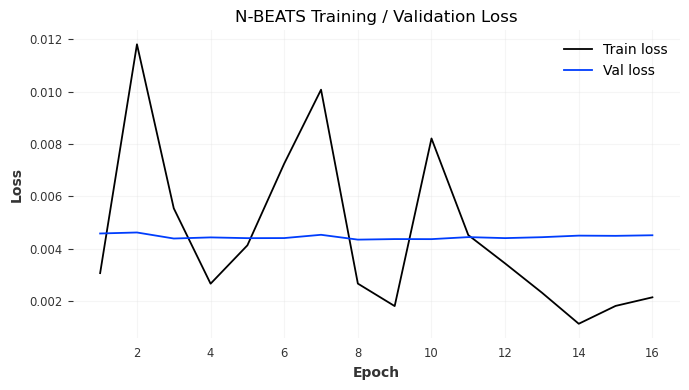

In [27]:
# Save + plot loss history
hist_df = loss_history8.to_frame()
display(hist_df.tail())          
hist_df.to_csv("loss_history8.csv", index=False)

plt.figure(figsize=(7,4))
plt.plot(hist_df["epoch"], hist_df["train_loss"], label="Train loss")
if "val_loss" in hist_df and hist_df["val_loss"].notna().any():
    plt.plot(hist_df["epoch"], hist_df["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("N-BEATS Training / Validation Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# Convert Darts TimeSeries to pandas Series
def ts_to_series(ts):
    if isinstance(ts, pd.Series):
        return ts
    
    idx = getattr(ts, "time_index", None)
    df  = pd.DataFrame(ts.values().squeeze(), index=idx)
    
    return df.iloc[:, 0] if isinstance(df, pd.DataFrame) else df

s_actual = ts_to_series(y_te_aligned)
s_pred   = ts_to_series(yhat_te_aligned)

In [29]:
# Align 
y_te_aligned   = series_te.slice_intersect(hist_fc_te)
yhat_te_aligned = hist_fc_te

# To pandas
s_actual = ts_to_series(y_te_aligned)
s_pred   = ts_to_series(yhat_te_aligned)

# Combine & drop NaNs
df_plot = pd.concat([s_actual.rename("actual"), s_pred.rename("pred")], axis=1).dropna()

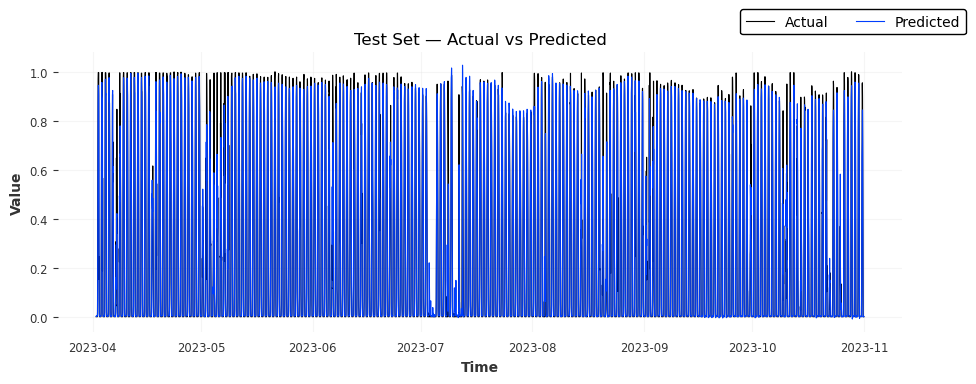

In [30]:
# Line plot
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df_plot.index, df_plot["actual"],  label="Actual",    linewidth=0.8, zorder=2)
ax.plot(df_plot.index, df_plot["pred"],    label="Predicted", linewidth=0.8, zorder=2)

ax.set_title("Test Set — Actual vs Predicted")
ax.set_xlabel("Time"); ax.set_ylabel("Value")
ax.grid(True, alpha=0.3)

# legend outside
ax.legend(loc="upper left", bbox_to_anchor=(0.8, 1.18), ncol=3,
          frameon=True, facecolor="white", framealpha=1.0, edgecolor="black")
plt.tight_layout()
plt.show()


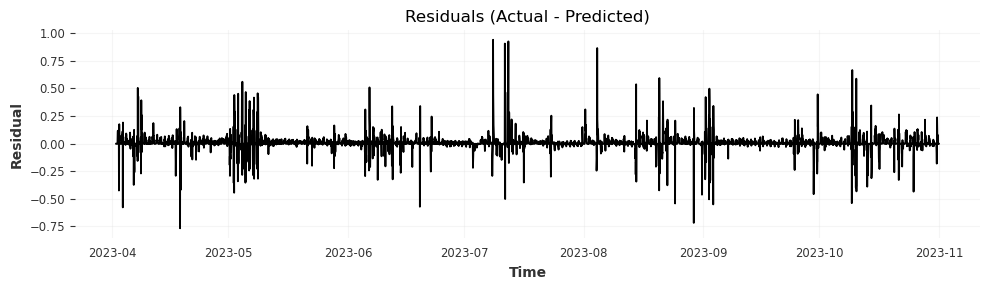

In [31]:
# Residual diagnostics 
resid = df_plot["actual"] - df_plot["pred"]
plt.figure(figsize=(10,3))
plt.plot(resid.index, resid.values)
plt.title("Residuals (Actual - Predicted)")
plt.xlabel("Time"); plt.ylabel("Residual")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

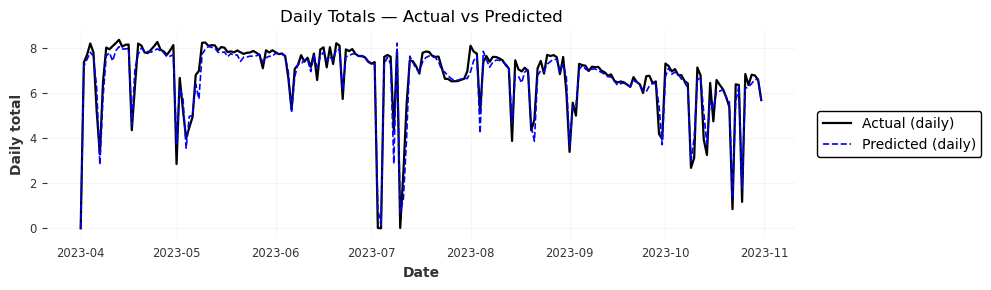

TEST (daily) sMAPE: 8.693767476512251
TEST (daily) RMSE : 0.3975259183001108
TEST (daily) MAE  : 0.2768456002584647
TEST (daily) nRMSE_mean% : 5.886%
TEST (daily) nRMSE_range%: 4.742%


In [32]:
# Daily totals
daily = df_plot.resample("D").sum(numeric_only=True)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(daily.index, daily["actual"],  label="Actual (daily)",
        color="black", linewidth=1.6)
ax.plot(daily.index, daily["pred"],    label="Predicted (daily)",
        color="blue",  linewidth=1.2, linestyle="--")

ax.set_title("Daily Totals — Actual vs Predicted")
ax.set_xlabel("Date"); ax.set_ylabel("Daily total")
ax.grid(True, alpha=0.3)

# legend to the RIGHT (outside)
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5),
          frameon=True, facecolor="white", framealpha=1.0, edgecolor="black")

# space on the right so legend isn’t cut off
plt.subplots_adjust(right=0.80)

# nice month ticks (optional)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.tight_layout()
plt.show()

# Metrics
from darts.metrics import rmse, smape, mae
from darts import TimeSeries
y_day    = TimeSeries.from_series(daily["actual"])
yhat_day = TimeSeries.from_series(daily["pred"])
rm = rmse(y_day, yhat_day)
yt = y_day.values().squeeze()
nrmse_mean  = 100 * rm / (np.mean(np.abs(yt)) + 1e-12)             # RMSE / mean(|y|)
nrmse_range = 100 * rm / (np.max(yt) - np.min(yt) + 1e-12) 
print("TEST (daily) sMAPE:", smape(y_day, yhat_day))
print("TEST (daily) RMSE :", rmse(y_day, yhat_day))
print("TEST (daily) MAE  :", mae(y_day, yhat_day))
print(f"TEST (daily) nRMSE_mean% : {nrmse_mean:.3f}%")
print(f"TEST (daily) nRMSE_range%: {nrmse_range:.3f}%")